# Основные этапы и предположения анализа

1. Добавим метрики на основе имеющихся данных: поездки отмененные из-за плохой модели и/или годы выпуска авто и поездки, плохо оцененные из-за плохой модели и/или годы выпуска авто. Также можно посчитать acceptance rate, cancelation rate, но, как мне кажется, эти метрики нам в меньшей мере будут полезны + Построим индекс плохих поездок, используя только метрики связанные именно с машиной. Использовать метрики, на которые влияет также и водитель - будет несправедливо для оценки качества модели и года выпуска авто. 
    - Можно объединить построенные метрики(я просто просуммировал, но можно сделать standard scaler и потом просуммировать) в некоторый индекс того, насколько плохая модель и/или год выпуска авто,  мы сможем отранжировать модели и/или годы выпуска по этому индексу (чем он ниже, тем лучше модель и год выпуска авто). 
    - Посмотрим, насколько полученный индекс плохих поездок коррелирует с текущим классификатором (спойлер - коэффициент корреляции низкий, поэтому менять классификатор стоит)
2. Построим классификатор на основе полученного индекса    
    - Оставим в классификаторе столько моделей, чтобы количество брендированных машин осталось, как при исходном классификаторе. Предположим, что необходимое количество брендированных машин яндекса = количество брендированных машин при исходном классификаторе, так как, вероятно, это количество было выбрано, чтобы не превысить выделенный на брендирование бюджет.
    - Выведем новый классификатор в отдельном столбце
    - Посмотрим, насколько полученный индекс плохих поездок коррелирует с новым классификатором (спойлер - коэффициент корреляции увеличился, то есть новый классификатор лучше показывает предпочтения пассажиров относительно моделей и годов выпуска машин)
3. Рассчитать, как изменилась экономика партнеров: 
    - сколько машин забрендирует каждый партнер, а со скольких машин, наоборот, придется снять оклейку при введении нового классификатора. Это краткосрочное изменение доходов партнеров: оклейка и снятие оклейки требует расходов, но делается единоразово). Предположим, что доля брендированных машин из тех, которые можно брендировать, сохранится, как при прошлом классификаторе
    - Рассчитать изменение количества машин, которые можно забрендировать (учитывая предположение выше - здесь можем говорить сразу и о количестве забрендированных машин), у каждого партнера. Это долгосрочное изменение доходов партнеров: количество брендированных машин влияет на доход партнера каждый месяц

In [316]:
import numpy as np
import pandas as pd

In [317]:
# импортируем данные
models = pd.read_excel('/Users/alexeysek/Downloads/models.xlsx', index_col=0)
partners = pd.read_excel('/Users/alexeysek/Downloads/partners.xlsx', index_col=0)

In [340]:
# Всего машин
total_cars = sum(models['car_cnt'])
total_cars

33893

In [318]:
# Будем считать, что необходимое количество машин в оклейке не изменилось и равно текущему количеству машин в оклейке
n_branded = sum(models['car_sticker_cnt'])
n_branded

5051

In [319]:
# Доля брендированных машин из тех, которые можно брендировать
branded_among_allowed_to_brand = sum(models['car_sticker_cnt']) / sum((models['can_be_branded'] * models['car_cnt']))
branded_among_allowed_to_brand

0.18858977709741254

In [320]:
# Количество машин, которые подходят под классификатор (их можно забрендировать)
can_be_branded = sum(models['can_be_branded'] * models['car_cnt'])
can_be_branded

26783

In [321]:
# Проверим данные на адекватность
# Например, не может быть дефектных заказов больше, чем оцененных заказов
if sum(models['trips_defect_cnt'] > models['trips_rated_cnt'])==0: print('ok')
if sum(models['bad_car_model_tag_cnt'] > models['trips_cancel_cnt'])==0: print('ok')
if sum(models['dissapointed_car_model_tag_cnt'] > (models['trips_rated_cnt']))==0: print('ok')

ok
ok
ok


In [322]:
# При выборе моделей авто важнее рассматривать именно те метрики, которые зависят именно от модели авто
# Например, defect rate зависит также и от водителя, поэтому несправедливо исключать модели авто только за то, что 
# водители у такой модели в нашей выборке были, например, не очень вежливыми

# Доля заказов, в которых клиент не доволен моделью машины, среди всех оцененных заказов
# У нас нет столбца с успешными заказами с рейтингом ниже 5, поэтому буду делить на все оцененные заказы
models['disappointed_model_rate'] = models['dissapointed_car_model_tag_cnt'] / (models['trips_rated_cnt'])
# Доля заказов, которые отменили именно из-за плохой модели среди всех отмененных заказоов
models['bad_model_rate_cancel'] = models['bad_car_model_tag_cnt'] / (models['trips_cancel_cnt'])

# Добавим некоторый агрегированный показатель-индекс из первых двух
# Он показывает долю заказов отмененных или плохо оцененных из-за плохой модели машины 
# среди всех отмененных и оцененных заказов
models['bad_model_index'] = (
    (models['dissapointed_car_model_tag_cnt'] + models['bad_car_model_tag_cnt']) / 
    (models['trips_rated_cnt'] + models['trips_cancel_cnt'])
)



# Добавим и некоторые другие метрики, которые могут оказаться полезными
# Доля успешных заказов среди всех заказов
models['success_rate'] = models['trips_success_cnt'] / (models['trips_success_cnt'] + models['trips_cancel_cnt'])
models['cancel_rate'] = models['trips_cancel_cnt'] / (models['trips_success_cnt'] + models['trips_cancel_cnt'])
# Доля заказов с оценкой ниже 4 среди всех оцененных заказов
models['defect_rate'] = models['trips_defect_cnt'] / (models['trips_rated_cnt'])
# Доля заказов, где указали плохую модель, среди всех отмененных заказов
models['bad_model_rate'] = models['bad_car_model_tag_cnt'] / (models['trips_cancel_cnt'])

In [323]:
# Выделим год выпуска в отдельный числовой столбец (изначально он текстовый)
models['year'] = pd.to_numeric(models['year'].str.slice(5,10))

In [324]:
models

,model,year,can_be_branded,car_cnt,car_sticker_cnt,trips_success_cnt,trips_cancel_cnt,trips_defect_cnt,trips_rated_cnt,bad_car_model_tag_cnt,dissapointed_car_model_tag_cnt,disappointed_model_rate,bad_model_rate_cancel,bad_model_index,success_rate,cancel_rate,defect_rate,bad_model_rate
0,model_207,20,False,1,0,12,3,0,5,0,0,0.000000,0.000000,0.000000,0.800000,0.200000,0.000000,0.000000
1,model_482,19,False,1,0,12,4,0,4,0,0,0.000000,0.000000,0.000000,0.750000,0.250000,0.000000,0.000000
2,model_499,7,False,1,0,46,1,0,14,0,0,0.000000,0.000000,0.000000,0.978723,0.021277,0.000000,0.000000
3,model_499,8,False,3,0,1592,198,10,510,5,1,0.001961,0.025253,0.008475,0.889385,0.110615,0.019608,0.025253
4,model_499,9,False,2,0,49,8,0,14,0,0,0.000000,0.000000,0.000000,0.859649,0.140351,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2962,model_451,24,False,2,0,3,1,0,0,0,0,NaN,0.000000,0.000000,0.750000,0.250000,NaN,0.000000
2963,model_451,25,False,1,0,7,1,0,3,0,0,0.000000,0.000000,0.000000,0.875000,0.125000,0.000000,0.000000
2964,model_77,29,True,5,0,800,62,3,252,2,2,0.007937,0.032258,0.012739,0.928074,0.071926,0.011905,0.032258
2965,model_77,30,True,1,0,960,183,20,519,4,2,0.003854,0.021858,0.008547,0.839895,0.160105,0.038536,0.021858


In [325]:
# Посмотрим количество пропусков данных
models.isna().sum()

model                               0
year                                0
can_be_branded                      0
car_cnt                             0
car_sticker_cnt                     0
trips_success_cnt                   0
trips_cancel_cnt                    0
trips_defect_cnt                    0
trips_rated_cnt                     0
bad_car_model_tag_cnt               0
dissapointed_car_model_tag_cnt      0
disappointed_model_rate           121
bad_model_rate_cancel             233
bad_model_index                    81
success_rate                        0
cancel_rate                         0
defect_rate                       121
bad_model_rate                    233
dtype: int64

In [326]:
# Когда недостаточно данных - мы делим на 0 (например, не было поездок вообще) и получаем nan
# С точки зрения бизнеса, если мы не знаем, хороша ли модель и год авто или нет - лучше считать ее плохой
# Например, всего 2 машины жигули 20 года, информации о них мало, лучше пока не включать в классификатор такие машины, 
# чем включать машины, которые могут оказаться непривлекательными для пассажиров,
# поэтому я заполню пропуски единицами (наши метрики показывают то, насколько модель плохая от 0 до 1: выше=хуже)
models = models.fillna(1)

In [377]:
# Просто посчитаем корреляции в среднем по моделям для моделей, которые можно брендировать
# по текущему классификатору с некоторыми метриками удовлетворенности пассажиров
print(np.corrcoef(models.groupby('model').mean()['bad_model_rate_cancel'], models.groupby('model').mean()['can_be_branded'])[1][0])
print(np.corrcoef(models.groupby('model').mean()['disappointed_model_rate'], models.groupby('model').mean()['can_be_branded'])[1][0])
print(np.corrcoef(models.groupby('model').mean()['bad_model_index'], models.groupby('model').mean()['can_be_branded'])[1][0])
# Как видим, значение коэффициентов корреляции низкое - предварительно можно сказать, 
# что текущий классификатор плохо связан с тем, какие автомобили приятны пассажирам
# Предположим, что предпочтения водителей близки к предпочтениям пассажиров

-0.14722299109290518
-0.13003613041324388
-0.10459575532398262


<AxesSubplot:>

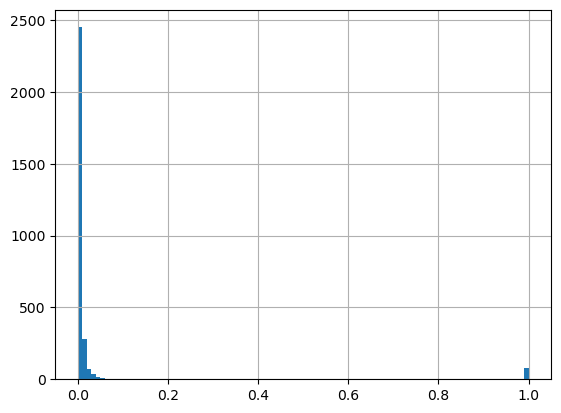

In [328]:
models['bad_model_index'].hist(bins=100)

In [329]:
# Идея в том, чтобы оставить столько же машин, которым можно брендироваться, сколько их было в прошлом классифкаторе
# Именно машин, а не моделей!
can_be_branded_error = []
arglist = list(np.arange(0,0.1,0.0001))

for i in np.arange(0,0.1,0.0001):
    temp_sum = sum((models['bad_model_index'] < i) * models['car_cnt'])
    can_be_branded_error.append(abs(can_be_branded-temp_sum))

max_bad_car_index = arglist[can_be_branded_error.index(min(can_be_branded_error))]
max_bad_car_index

0.007200000000000001

In [330]:
# Выведем новый классифкатор в отдельный столбец
# Возможная проблема - из-за небольшого размера выборки у некоторых моделей машины моложе могли быть не включены
# а машины старше включены. На большой выборке этот эффект должен сойти на нет
# Можно бы было сначала отобрать модели машин, а потом уже отбирать возраст,
# но я ограничусь упрощенным вариантом, где возможна указанная выше проблема
models['can_be_branded_NEW'] = models['bad_model_index'] < max_bad_car_index
models

,model,year,can_be_branded,car_cnt,car_sticker_cnt,trips_success_cnt,trips_cancel_cnt,trips_defect_cnt,trips_rated_cnt,bad_car_model_tag_cnt,dissapointed_car_model_tag_cnt,disappointed_model_rate,bad_model_rate_cancel,bad_model_index,success_rate,cancel_rate,defect_rate,bad_model_rate,can_be_branded_NEW
0,model_207,20,False,1,0,12,3,0,5,0,0,0.000000,0.000000,0.000000,0.800000,0.200000,0.000000,0.000000,True
1,model_482,19,False,1,0,12,4,0,4,0,0,0.000000,0.000000,0.000000,0.750000,0.250000,0.000000,0.000000,True
2,model_499,7,False,1,0,46,1,0,14,0,0,0.000000,0.000000,0.000000,0.978723,0.021277,0.000000,0.000000,True
3,model_499,8,False,3,0,1592,198,10,510,5,1,0.001961,0.025253,0.008475,0.889385,0.110615,0.019608,0.025253,False
4,model_499,9,False,2,0,49,8,0,14,0,0,0.000000,0.000000,0.000000,0.859649,0.140351,0.000000,0.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2962,model_451,24,False,2,0,3,1,0,0,0,0,1.000000,0.000000,0.000000,0.750000,0.250000,1.000000,0.000000,True
2963,model_451,25,False,1,0,7,1,0,3,0,0,0.000000,0.000000,0.000000,0.875000,0.125000,0.000000,0.000000,True
2964,model_77,29,True,5,0,800,62,3,252,2,2,0.007937,0.032258,0.012739,0.928074,0.071926,0.011905,0.032258,False
2965,model_77,30,True,1,0,960,183,20,519,4,2,0.003854,0.021858,0.008547,0.839895,0.160105,0.038536,0.021858,False


In [378]:
# Видим, что модуль коэффициента корреляции значительно повысился относительно прошлого классификатора
print(np.corrcoef(models.groupby('model').mean()['bad_model_rate_cancel'], models.groupby('model').mean()['can_be_branded_NEW'])[1][0])
print(np.corrcoef(models.groupby('model').mean()['disappointed_model_rate'], models.groupby('model').mean()['can_be_branded_NEW'])[1][0])
print(np.corrcoef(models.groupby('model').mean()['bad_model_index'], models.groupby('model').mean()['can_be_branded_NEW'])[1][0])

-0.21221988961663366
-0.324843838930774
-0.4566257017953916


In [ ]:
# Выделим год выпуска в отдельный числовой столбец (изначально он текстовый)
partners['year'] = pd.to_numeric(partners['year'].str.slice(5,10))

In [335]:
partners_new = pd.merge(partners, models[['model', 'year', 'can_be_branded', 'can_be_branded_NEW']],  how='left', left_on=['model','year'], right_on = ['model','year'])
partners_new

,partner,model,year,car_cnt,car_sticker_cnt,can_be_branded,can_be_branded_NEW
0,partner_6613,model_147,30,1,0,True,True
1,partner_7944,model_615,26,1,1,True,True
2,partner_7944,model_576,29,1,1,True,True
3,partner_7944,model_576,30,1,0,True,True
4,partner_7944,model_362,23,1,0,False,True
...,...,...,...,...,...,...,...
33785,partner_3447,model_416,32,1,0,True,True
33786,partner_3969,model_576,26,1,0,True,True
33787,partner_5479,model_256,18,1,0,True,True
33788,partner_4734,model_425,30,1,1,False,True


In [343]:
# По какой-то причине в этом датасете больше машин, чем в датасете по моделям
# Больше и машин всего, и брендированных
sum(partners_new['car_cnt'])

41016

In [344]:
sum(partners_new['car_sticker_cnt'])

6717

In [348]:
print('можно брендировать в старом классификаторе:', sum(partners_new['car_cnt'] * partners_new['can_be_branded']))
print('можно брендировать в новом классификаторе:', sum(partners_new['car_cnt'] * partners_new['can_be_branded_NEW']))

можно брендировать в старом классификаторе: 32730
можно брендировать в новом классификаторе: 32683


In [372]:
# Добавим количество машин, которые попадают под старый и новый классификатор (не модели, а машины)
partners_new['cars_can_be_branded'] = partners_new['car_cnt'] * partners_new['can_be_branded']
partners_new['cars_can_be_branded_NEW'] = partners_new['car_cnt'] * partners_new['can_be_branded_NEW']

# Также нужно посчитать, со скольких машин каждый партнер должен снять оклейку, а на сколько добавить оклейку
# Добавим столбец, который показывает со скольких машин, нужно снимать оклейку
partners_new['cars_need_to_unbrand'] = partners_new['car_sticker_cnt'] * ((partners_new['can_be_branded']*1 - partners_new['can_be_branded_NEW']*1)==1)

# Добавим столбец, который показывает на сколько машин, нужно добавить оклейку
# (предположение: доля брендированных из тех, которые можно брендировать не поменяется)
partners_new['cars_to_be_branded'] = branded_among_allowed_to_brand * partners_new['car_cnt'] * ((partners_new['can_be_branded']*1 - partners_new['can_be_branded_NEW']*1)==-1)

# Посчитаем, на сколько повысилось количество машин, которые может забрендировать каждый партнер
partners_new_groupped = partners_new.groupby('partner').sum()
partners_new_groupped['increase_in_cars_can_be_branded'] = partners_new_groupped['cars_can_be_branded_NEW'] - partners_new_groupped['cars_can_be_branded']
partners_new_groupped

,year,car_cnt,car_sticker_cnt,can_be_branded,can_be_branded_NEW,cars_can_be_branded,cars_can_be_branded_NEW,cars_need_to_unbrand,cars_to_be_branded,increase_in_cars_can_be_branded
partner,,,,,,,,,,
partner_0,29,1,1,1,1,1,1,0,0.00000,0
partner_1,25,1,0,0,0,0,0,0,0.00000,0
partner_10,22,1,0,0,0,0,0,0,0.00000,0
partner_100,35,1,0,1,1,1,1,0,0.00000,0
partner_1000,135,5,0,4,4,4,4,0,0.18859,0
...,...,...,...,...,...,...,...,...,...,...
partner_995,24,1,0,0,0,0,0,0,0.00000,0
partner_996,31,1,1,1,1,1,1,0,0.00000,0
partner_997,30,1,0,1,1,1,1,0,0.00000,0


/Users/alexeysek/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='increase_in_cars_can_be_branded', ylabel='Density'>

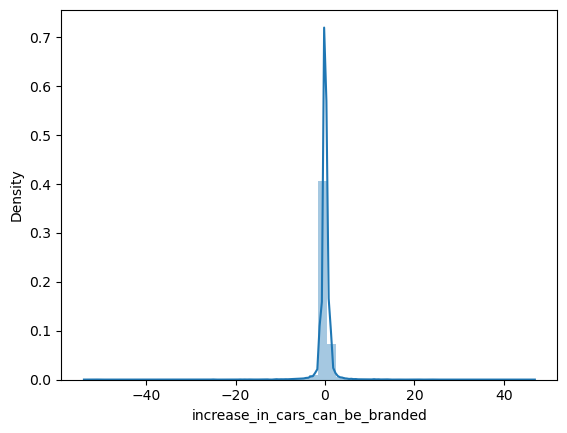

In [374]:
# Можем заметить, что экономика партнеров при таком подходе в долгосроке не изменится
# Но в моменте будут дополнительные расходы на снятие оклейки с исключенных из классификатора моделей
# и расходы на оклейку включенных в классификатор моделей
sns.distplot(partners_new_groupped['increase_in_cars_can_be_branded'])

/Users/alexeysek/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='cars_to_be_branded', ylabel='Density'>

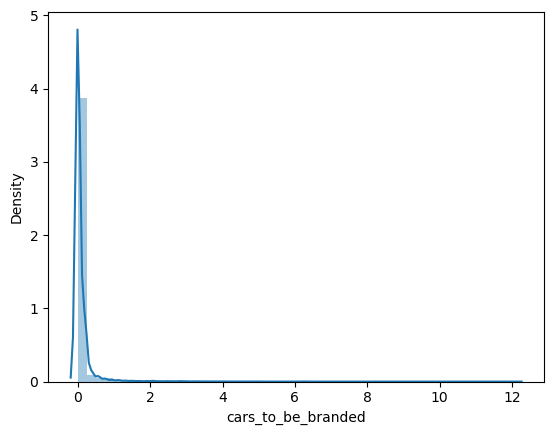

In [375]:
# Для большинства таксопарков количество машин, на которые они добавят оклейку - меньше двух
sns.distplot(partners_new_groupped['cars_to_be_branded'])

/Users/alexeysek/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='cars_need_to_unbrand', ylabel='Density'>

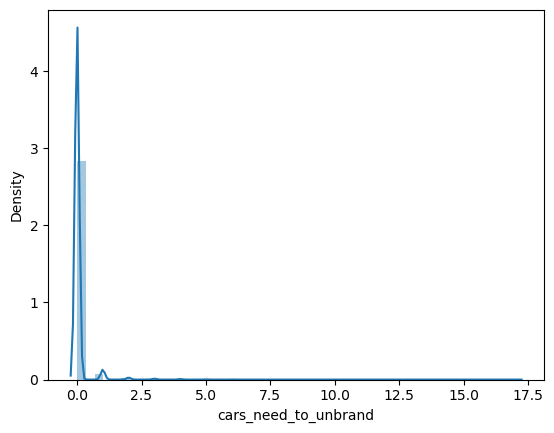

In [376]:
# Для большинства таксопарков количество машин, с которых нужно будет снять оклейку - меньше двух
sns.distplot(partners_new_groupped['cars_need_to_unbrand'])